# Deepdream

## Setup

In [ ]:
from collections import Counter, defaultdict
import math
import torch
import torch.nn.functional as F
import PIL
import copy
from tqdm.auto import tqdm
import torchvision.models as models
import transformers
from transformers import AutoImageProcessor, ResNetForImageClassification
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# load from torchvision pre-trained VGG19
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
# load things from huggingface
transformers.logging.set_verbosity_error() # suppress warnings
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50") # for imagenet labels
do_normalize = False # keep images human readable
# labels
id2label = resnet.config.id2label

## Helpers

In [ ]:
# plot the image and optinal labels in a grid
def plot(*args, n_col=None, figsize=None, axis_off=True):
    '''Plot the images in a grid with optional labels'''
    # prepare the elements to plot as (image, label)
    elems = []
    for el in args:
        if isinstance(el, torch.Tensor):
            if el.dim() == 4: el = el[0] # if picture is a batch, take the first one
            assert el.dim() == 3, f"Wrong image shape {el.shape}"
            if el.shape[0] == 3: el = el.permute(1, 2, 0)
            if el.requires_grad: el = el.detach()
            elems.append([el])
        elif isinstance(el, str): elems[-1].append(el)
        else: raise ValueError(f"Wrong element ({type(el)}) {repr(el)}")
    elems = [(el[0], el[1] if len(el) == 2 else None) for el in elems]

    # plot the images
    n_col = n_col or len(elems)
    n_row = math.ceil(len(elems) / n_col)
    figsize = figsize or (n_col * 4, n_row * 4)
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = [ax]
    for i, (img, label) in enumerate(elems):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if label: ax.__getitem__(*idx).set_title(label) # use __getitem__() because [] mess up the * operator somehow
        ax.__getitem__(*idx).imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if axis_off: ax.__getitem__(*idx).axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# classify things
@torch.no_grad()
def classify(img, model):
    logits = model.to(device)(img.to(device))
    if not isinstance(logits, torch.Tensor): logits = logits.logits
    confidence = logits.softmax(dim=-1).max()
    label = id2label[logits.argmax(dim=-1).item()]
    return label, confidence

def all_classify(img):
    res = []
    models = [
        ('VGG19', vgg),
        ('ResNet', resnet)
    ]
    for name, model in models:
        label, confidence = classify(img, model)
        if len(label) > 20: label = label[:20] + '...'
        res.append(f'{name:6}: {label:23} ({confidence*100:.2f}%)')
    return '\n'.join(res)

def plotl(*args):
    '''expecting tuples of (image, label)'''
    av = []
    for img, label in args:
        av.append(img)
        av.append(f'{label}\n{all_classify(img)}')
    plot(*av)

In [ ]:
# hook some activation layer
def hook(layer, k, mem=None):
    if mem is None: mem = {}
    def f(module, input, output):
        mem[k] = output
    layer.register_forward_hook(f)
    return mem

def hooked(model):
    m = copy.deepcopy(model).to(device)
    mem = {}
    for layer in range(37):
        mem = hook(m.features[layer], layer, mem=mem)
    return mem, m

In [141]:
def disable_tqdm(f):
    def wrapper(*args, **kwargs):
        try:
            original_tqdm = tqdm
            globals()['tqdm'] = lambda x: x
            result = f(*args, **kwargs)
        finally:
            globals()['tqdm'] = original_tqdm
        return result
    return wrapper

## Load images

In [ ]:
original_vangogh = PIL.Image.open('vangogh.jpg')
original_sky = PIL.Image.open('sky.jpg')
original_kelpie = PIL.Image.open('kelpie.jpg')
vangogh = processor(original_vangogh, return_tensors='pt', do_normalize=do_normalize)['pixel_values']
sky = processor(original_sky, return_tensors='pt', do_normalize=do_normalize)['pixel_values']
kelpie = processor(original_kelpie, return_tensors='pt', do_normalize=do_normalize)['pixel_values']

kelpies = [kelpie]
for i in range(2, 6):
    kelpies.append(processor(PIL.Image.open(f'kelpie{i}.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values'])

plot(vangogh, sky, *kelpies)

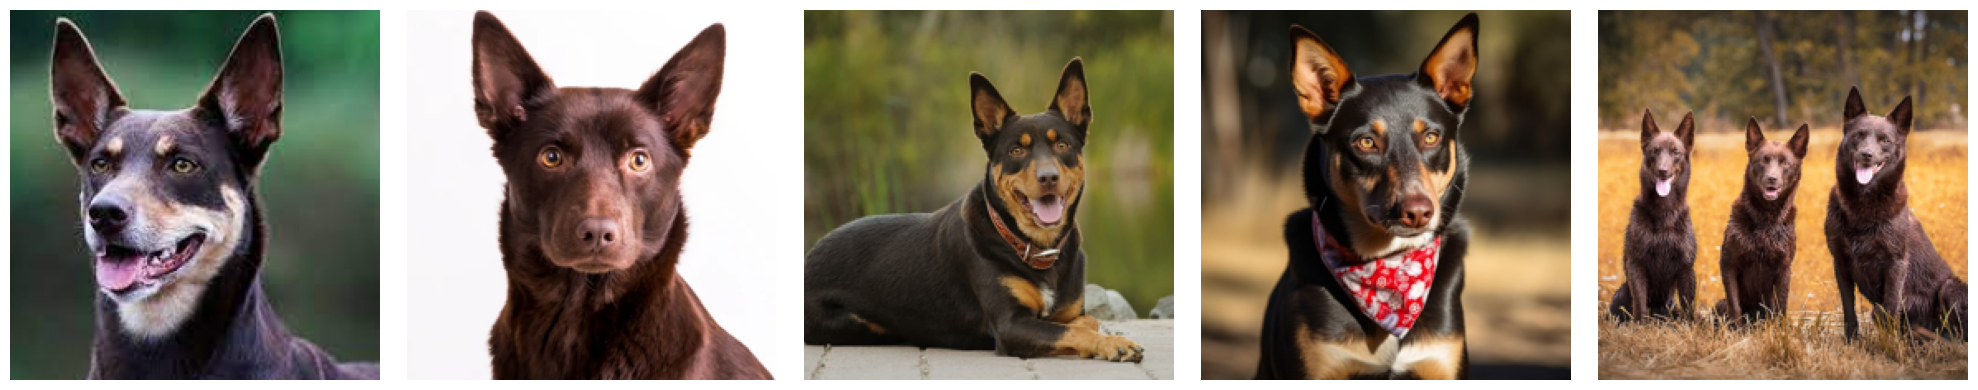

In [122]:
plot(*kelpies)

## VGG from torchvision

In [ ]:
vgg_mem, vgg_hooked = hooked(vgg)
# the VGG model on torchvision is much easier to look into than ResNet from huggingface
vgg_hooked.features

## dream

In [ ]:
def shallowdream(start, layer=35, channel=None, m=vgg_hooked, mem=vgg_mem, learning_rate=0.01, epochs=30):
    start = copy.deepcopy(start.detach())
    # move to device
    dream = start.to(device).requires_grad_()
    m = m.to(device)

    for epoch in tqdm(range(epochs)):
        m(dream)
        loss = mem[layer].norm() if channel is None else mem[layer][:, channel, :, :].norm()
        dream.grad = None
        loss.backward()
        dream.data = torch.clip((dream + dream.grad * learning_rate), 0., 1.).data # jumping through hoops to please pytorch
    return dream

dream = shallowdream(vangogh, layer=28, learning_rate=0.02, epochs=20).to('cpu')
plot(vangogh, 'starting point',
     dream, 'dream')

## mechanistic interpretability
find the channels that are most activated in each layer when fed pictures of kelpies

### Identify channels

In [ ]:
def save_activations(start, m=vgg_hooked, mem=vgg_mem):
    # move to device
    dream = start.to(device).requires_grad_()
    m = m.to(device)
    # run the model
    m(dream)
    # make a copy of the activations
    activations = {k: copy.deepcopy(output.detach()) for k, output in mem.items()}
    return activations

all_activations = [save_activations(kelpie) for kelpie in kelpies]

In [ ]:
# compute the top n channels with the highest norm
def topn(activation, n, threshold):
  channels = activation.shape[1]
  top = sorted(zip(activation.view(channels, -1).norm(dim=1), range(channels)), reverse=True)[:n]
  return [idx for norm, idx in top if norm > threshold]

def topn_activations(activations, n=10, threshold=0):
  return {k: topn(activation, n=n, threshold=threshold) for k, activation in activations.items()}

all_topn = [topn_activations(activations) for activations in all_activations]

In [ ]:
def count_topn(all_topn):
  counts = defaultdict(Counter)
  for topn in all_topn:
    for layer, top in topn.items():
      counts[layer].update(top)
  return counts

counts = count_topn(all_topn)

### dream of channels

In [ ]:
@disable_tqdm
def plot_counts(counts, kelpies, most_common=5, threshold=4):
  for layer, count in counts.items():
    # XXX
    if layer < 22: continue
    for channel, occurences in count.most_common(most_common):
      if occurences < threshold: break
      dreams = []
      # for idx, kp in enumerate(kelpies + [torch.ones_like(kelpies[0]) * 0.5]):
      for idx, kp in enumerate(kelpies):
        dreams.append(shallowdream(kp, layer=layer, channel=channel, learning_rate=0.05, epochs=20).to('cpu'))
        dreams.append(f'{layer=} {channel=} {occurences=}')
      plot(*dreams)

plot_counts(counts, kelpies)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

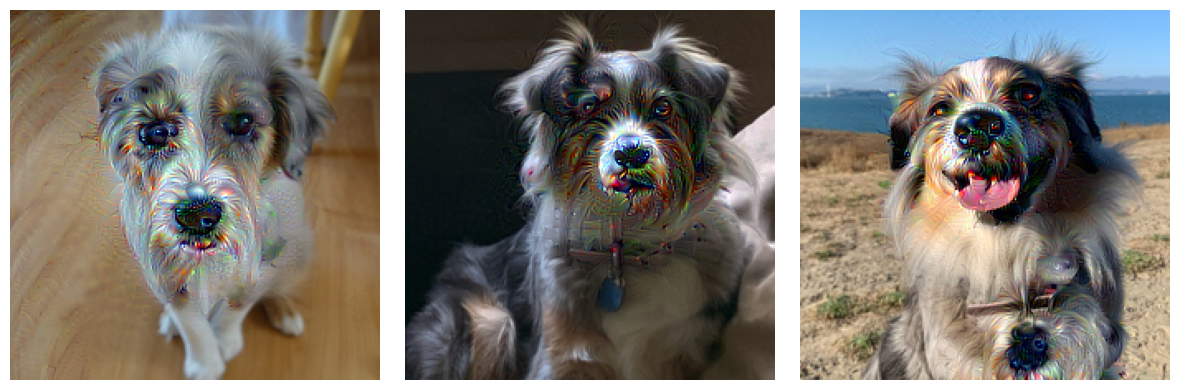

In [121]:
# 28 114
ds = []
for d in dogs:
    ds.append(shallowdream(d, layer=28, channel=114, learning_rate=0.02, epochs=40).to('cpu'))
plot(*ds)

In [ ]:
grey = torch.ones_like(kelpies[0]) * 0.5
dream = shallowdream(grey, layer=24, channel=234, learning_rate=0.05, epochs=30).to('cpu')
plot(dream)

## dream by layer

In [ ]:
start = sky
for layer in range(1, 36):
    dream = shallowdream(start, layer=layer, learning_rate=0.02, epochs=30).to('cpu')
    plot(start, 'starting point',
        dream, f'dream {layer=}')

## dream of creatures?

In [ ]:
start = kelpie
# layer = 25 # building?
layer = 27 # creatures?
# layer = 30 # mountain?
# layer = 34 # bigger creatures?
for duration in range(10, 300, 50):
    dream = shallowdream(start, layer=layer, learning_rate=0.02, epochs=duration).to('cpu')
    plot(start, 'starting point',
         dream, f'dream {duration=}')

## random demos

In [ ]:
for start in [kelpie, sky, vangogh]:
    for layer in range(1, 36):
        dream = shallowdream(start, layer=layer, learning_rate=0.02, epochs=30).to('cpu')
        plot(start, 'starting point',
            dream, f'dream {layer=}')

## with noise

In [ ]:
start = torch.randn_like(vangogh) * 0.2
start = torch.zeros_like(vangogh)
start = circle
for layer in range(1, 36):
    dream = shallowdream(start, layer=layer, learning_rate=0.02, epochs=80).to('cpu')
    plot(start, 'starting point',
        dream, f'dream {layer=}')

## blinder
make VGG19 oblivious to kelpies

### load images

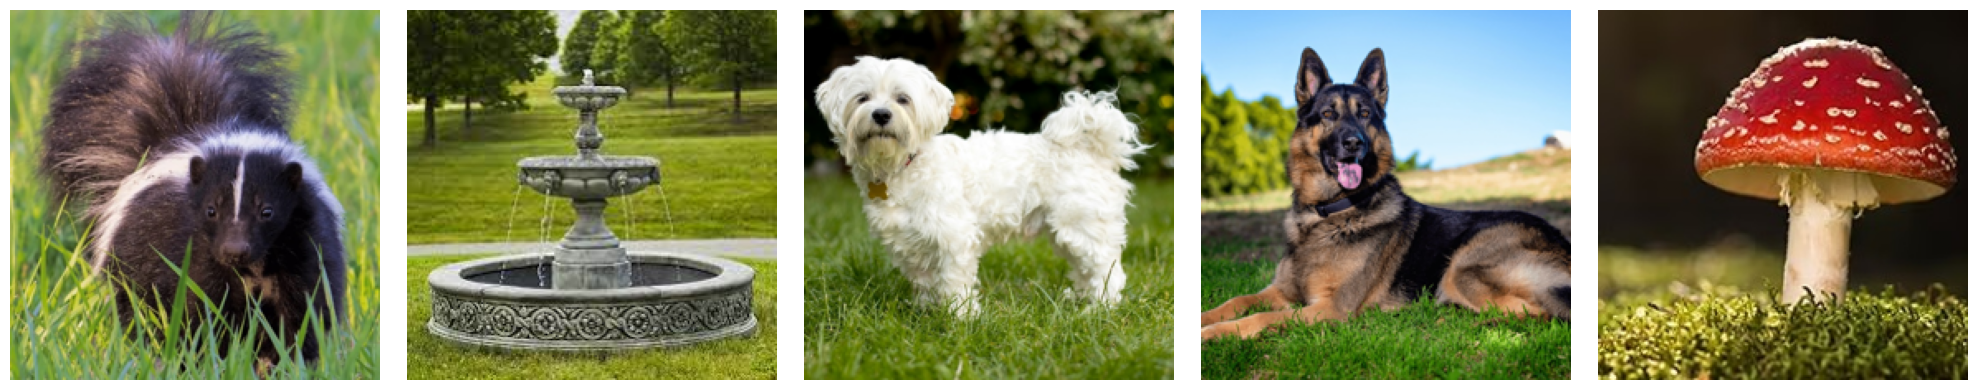

In [224]:
skunk = processor(PIL.Image.open(f'skunk.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values']
fountain = processor(PIL.Image.open(f'fountain.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values']
maltese = processor(PIL.Image.open(f'maltese.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values']
germanshepherd = processor(PIL.Image.open(f'germanshepherd.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values']
mushroom = processor(PIL.Image.open(f'mushroom.jpg'), return_tensors='pt', do_normalize=do_normalize, crop_pct=0.99)['pixel_values']
plot(skunk, fountain, maltese, germanshepherd, mushroom)

### blinder

In [175]:
def blinder(counts, model, most_common=5, threshold=4):
  # nuke a channel
  def nuke(layer, channel):
      def f(module, input, output):
          output[:, channel, :, :] = 0.
      layer.register_forward_hook(f)

  m = copy.deepcopy(model).to(device)
  for layer, count in counts.items():
    if layer < 20: continue # XXX
    for channel, occurences in count.most_common(most_common):
      if occurences < threshold: break
      nuke(m.features[layer], channel)
  return m

vgg_blind = blinder(counts, vgg)

In [220]:
@torch.no_grad()
def evaluate_blinder(img):
    res = []
    models = [
        ('VGG19', vgg.eval()),
        ('blinded', vgg_blind.eval()),
    ]
    for name, model in models:
        label, confidence = classify(img, model)
        if len(label) > 20: label = label[:20] + '...'
        res.append(f'{name:8}: {label:23} ({confidence*100:.2f}%)')
    return '\n'.join(res)

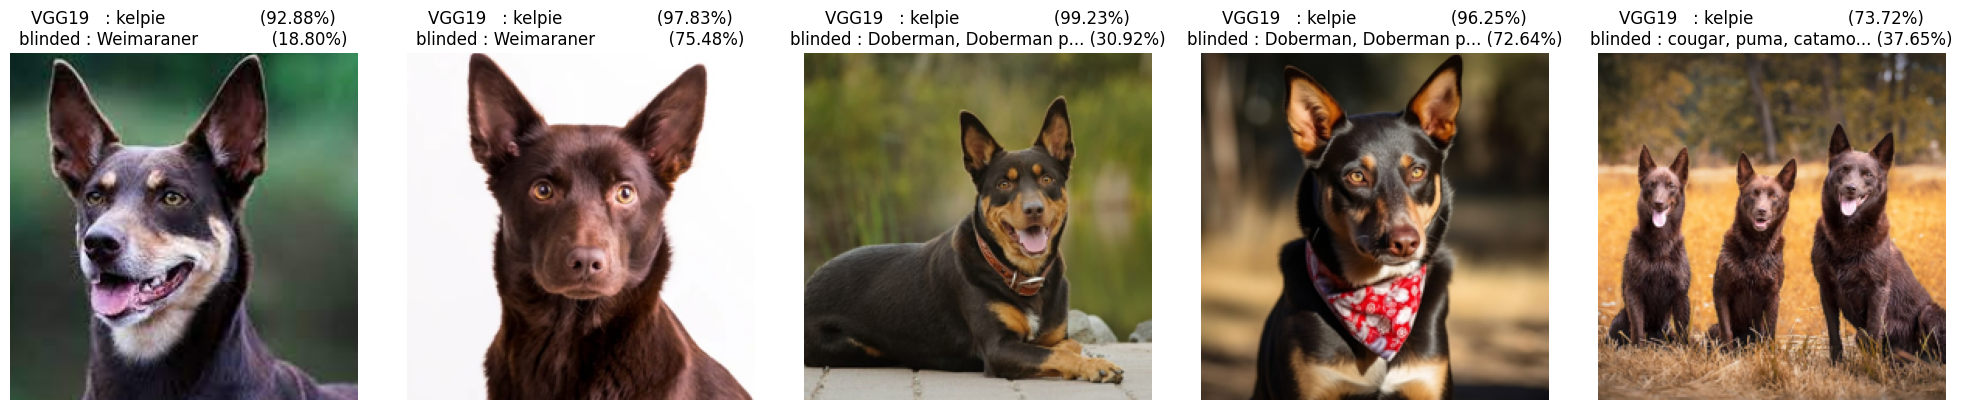

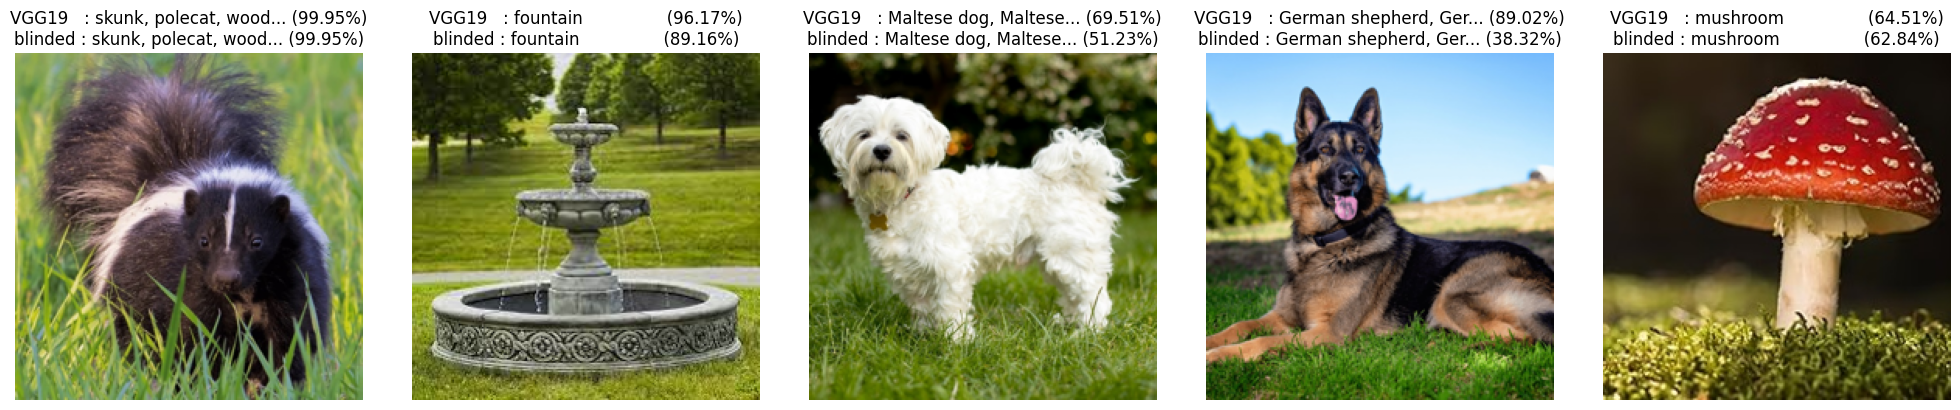

In [226]:
res = []
imgs = kelpies + [skunk, fountain, maltese, germanshepherd, mushroom]
for im in imgs:
    res.append(im)
    res.append(evaluate_blinder(im))
plot(*res[:10])
plot(*res[10:])

In [223]:
for l in id2label.values():
    if 'mush' in l:
        print(l)

mushroom
